# Задание 8

## 1. Wiki philosophy (0.5 баллов)
Существует шуточный «закон Философии» для статей Википедии: если переходить по
первой нормальной ссылке в статье, то рано или поздно мы придем на статью о философии.
Ваша задача заключается в том, чтобы проверить этот закон.
Для этого нужно написать программу, которая получает на вход ссылку на статью Википедии, а потом циклически переходит по первой нормальной ссылке и повторяет эту операцию
(до тех пор, пока не будет достигнута статья о философии, или ссылки не зациклятся). Нормальной ссылкой будем называть ссылку, которая находится в основном содержании статьи,
не в инфобоксах и не в служебных блоках, написана синим цветом (красный соответствует
несуществующей статье), не курсивом, не являтся сноской и не находится в скобках.

<b>Результат</b> должен представлять из себя несколько статистик (проверьте не менее 100 стр., <i>больше - лучше</i>):
* Описание алгоритма, как вы решали, стр. по философии или нет?
* Количество начальных ссылок vs Количество конечных тем страниц (0 - стр. не по философии, 1 - по философии).
* Гистограмма длин путей.
* Соотношений успешных и неуспешных запросов.
* Что еще можно тут придумать? :)

<b>Обратите внимание</b>, что для проверки нормальности не обязательно разбирать таблицы стилей и
проверять цвет и т.п., достаточно сделать, чтобы программа работала для текущей верстки
википедии (например, можно использовать атрибут class у тегов).
Для удобства проверки сделайте, чтобы последовательность переходов выводилась на
экран.

<b>Внимание.</b> Чтобы не создавать большую нагрузку на сервер Википедии, сделайте так,
чтобы ваша программа делала не более 2-х запросов в секунду. Для этого воспользуйтесь
функцией sleep из модуля time.

<b>PS</b> Лучше выполнять не в ipython notebook, а прислать отчет в pdf и код.

### Описание алгоритма

Один из вариантов закона заключается в том, чтобы перейти на статью с заголовком Философия, то есть на конкретную страницу [Философия](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D0%BE%D1%81%D0%BE%D1%84%D0%B8%D1%8F) 

In [219]:
from requests import get, post
import urllib
import urllib.parse
from bs4 import BeautifulSoup
import bs4.element
from IPython.core.display import display, HTML
import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3)

In [220]:
wiki_url = 'https://ru.wikipedia.org'

def first_link_in_element(element):
    # если в таблице(инфобоксе), то пропускаем
    if 'table' in list(map(lambda x: x.name, element.parents)):
        return None

    # удаляем всё что в скобках
    el = BeautifulSoup(str(re.sub('[^_]\([^)]*\)', u'', str(element))))
    for a in el.find_all('a', recursive=True):

        # если сноска(reference), пропускаем
        if a.parent.has_attr('class') and 'reference' in a.parent['class']:
            continue

        # несозданная страница или ссылки на дружественные ресурсы 
        if a.has_attr('class') and ('new' in a['class'] or 'extiw' in a['class']):
            continue

        return wiki_url + a.get('href')
    
    return None

def first_link(url):
    response = get(url)
    html = response.text
    soup = BeautifulSoup(html, 'lxml')
    

    content_div = soup.find(id="mw-content-text").find(class_="mw-parser-output")
    # пустая страница
    if not content_div:
        return

    
    for element in content_div.find_all("p", recursive=True):
        article_link = first_link_in_element(element)
        if article_link:
            return article_link

    # некоторые страницы сделаны в виде списка  
    for element in content_div.find_all('ul', recursive=False):
        article_link = first_link_in_element(element)
        if article_link:
            return article_link
        
    for element in content_div.find_all('ol', recursive=False):
        article_link = first_link_in_element(element)
        if article_link:
            return article_link
        
    return None

In [221]:
# случайная статья, каждый раз новая
start_url = "https://ru.wikipedia.org/wiki/%D0%A1%D0%BB%D1%83%D0%B6%D0%B5%D0%B1%D0%BD%D0%B0%D1%8F:%D0%A1%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%B0%D1%8F_%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B0"
# философия
target_url = "https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D0%BE%D1%81%D0%BE%D1%84%D0%B8%D1%8F"

# сколько поисков делаем
n_iter = 100
path_lengths = []
success_num = 0

for i in tqdm(range(n_iter)):
    history = [start_url] 
    article_count = 0 
    print('Итерация:', i)
    
    while True:
        link = first_link(history[-1])

        if not link:
            print('В статье нет ссылок')
            break
            
        article_count += 1  
#         print(f'{article_count}. {link}')
        
        if link in history:
            print('Зациклились')
            break

        history.append(link)
        if link == target_url:
            print('Найдена философия')
            success_num += 1
            break

        time.sleep(0.6) 
        
    path_lengths.append(article_count)

Итерация: 0
Найдена философия
Итерация: 1
Зациклились
Итерация: 2
Найдена философия
Итерация: 3
Найдена философия
Итерация: 4
Найдена философия
Итерация: 5
Найдена философия
Итерация: 6
Найдена философия
Итерация: 7
Найдена философия
Итерация: 8
Найдена философия
Итерация: 9
Найдена философия
Итерация: 10
Найдена философия
Итерация: 11
Найдена философия
Итерация: 12
Найдена философия
Итерация: 13
Найдена философия
Итерация: 14
Найдена философия
Итерация: 15
Найдена философия
Итерация: 16
Зациклились
Итерация: 17
Найдена философия
Итерация: 18
Найдена философия
Итерация: 19
Найдена философия
Итерация: 20
Зациклились
Итерация: 21
Найдена философия
Итерация: 22
Найдена философия
Итерация: 23
Найдена философия
Итерация: 24
Найдена философия
Итерация: 25
Найдена философия
Итерация: 26
Зациклились
Итерация: 27
Найдена философия
Итерация: 28
Найдена философия
Итерация: 29
Зациклились
Итерация: 30
Найдена философия
Итерация: 31
Найдена философия
Итерация: 32
Найдена философия
Итерация: 33
Найд

In [222]:
print(success_num)

78


Страница "Философия" была достигнута в 78 из 100 случаев. Один раз попали на статью без ссылок, а в остальных случаях зациклились.

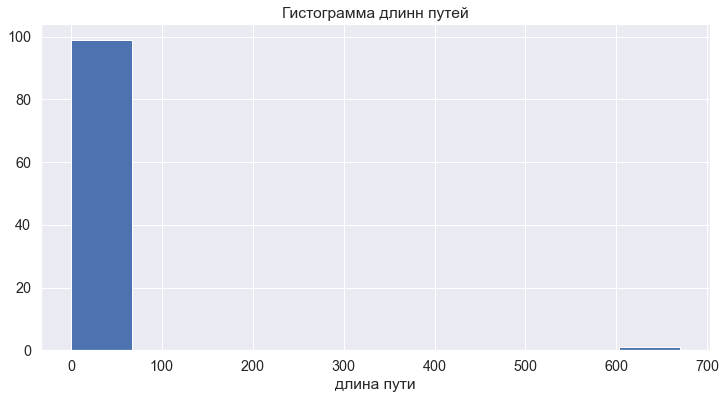

In [225]:
plt.figure(figsize=(12, 6))
plt.hist(path_lengths)
plt.title('Гистограмма длинн путей')
plt.xlabel('длина пути')
plt.show()

Виден какой-то выброс: был один или несколько путей очень большой длины.

In [226]:
path_lengths_arr = np.array(path_lengths)
path_lengths_arr[path_lengths_arr > 100]

array([670])

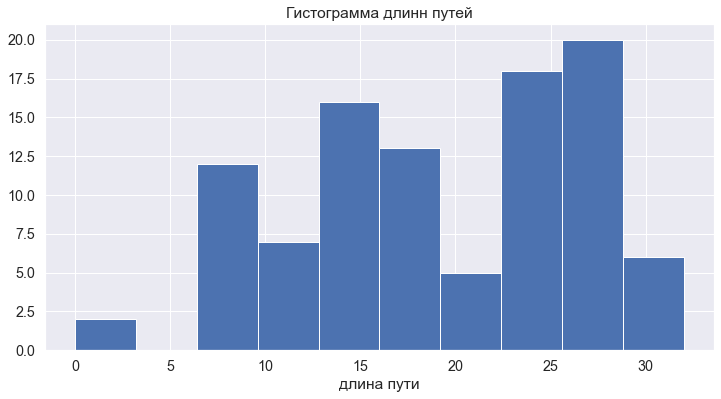

In [227]:
plt.figure(figsize=(12, 6))
# гистограмма без выброса
plt.hist(path_lengths_arr[path_lengths_arr < 100])
plt.title('Гистограмма длинн путей')
plt.xlabel('длина пути')

plt.show()

В основном преобладают длинные пути: от 15 и больше.

## 2. Books lib (0.5 баллов)
Напишите сайт-библиотеку для книг. Он должен удовлетворять следующему функционалу:
* Иметь одну главную страницу со списком авторов и ниже их произведений.
* Можно кликнуть на автора и получить список его произведений на отдельной стр.
* Можно кликнуть на книгу и получить текст книги на отдельной стр.
* Оформление и улучшение функционала приветствуются. Но можно обойтись заголовками и ссылками.

<b>Особенности реализации</b>:
* Список книг и авторов заранее не задан и должен быть создан автоматически. (<i>как - понятно из следующего описания</i>)
* Все книги хранятся по каталогам, которые имеют имя автора.
* Каждая книга имеет название, которое и будет показано в ссылке.
* Архив с книгами в папке с заданием (books.zip).
* Плюсом будет, если вы "замайните" книги, вместо использования случайного списка файлов (+0.2 балла).
* Использовать flask и bootstrap стили.

<b>PS</b> Лучше выполнять не в ipython notebook, а прислать отчет в pdf и код.

### Попробую сделать в конце семестра, если можно будет.